<a href="https://colab.research.google.com/github/iove4186/Canny_Detection/blob/main/Canny_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import cv2

import numpy as np
from matplotlib import pyplot as plt

import math

In [50]:
img = cv2.imread("test.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # transfer to gray
img = cv2.resize(img, (int(img.shape[0]/10), int(img.shape[1]/10)))

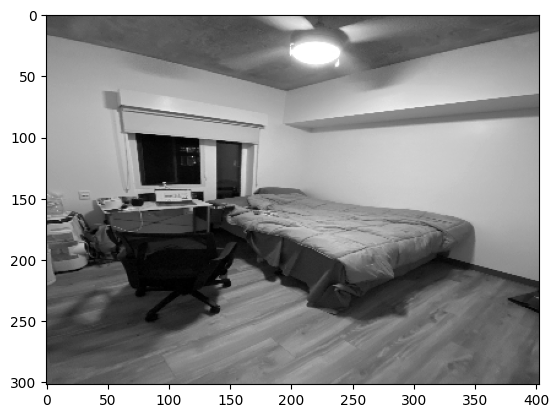

In [51]:
plt.imshow(img, cmap='gray')
plt.show()

In [89]:
class Canny:
  def gaussian_blur(self, img, kernel_size, sigma):
    kernel = np.zeros((kernel_size, kernel_size))
    half = int(kernel_size/2)

    #generate gaussian kernel
    for x in range(-half, half+1):
      for y in range(-half, half+1):
        kernel[x+half][y+half] = math.exp(-(x**2+y**2)/(2*sigma**2))/(2*math.pi*sigma**2)

    blur_img = np.zeros(img.shape)

    #convolution
    for x in range(half, img.shape[0]-half-1):
      for y in range(half, img.shape[1]-half-1):
        sub_matrix = img[x-half:x+half+1, y-half:y+half+1]
        blur_img[x][y] = np.sum(sub_matrix*kernel)

    return blur_img

  def sobel(self, img):
    #sobel kernel
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    half = 1
    gradient_x = np.zeros(img.shape)
    gradient_y = np.zeros(img.shape)

    #convolution
    for x in range(half, img.shape[0]-half-1):
      for y in range(half, img.shape[1]-half-1):
        sub_matrix = img[x-half:x+half+1, y-half:y+half+1]
        gradient_x[x][y] = np.sum(sub_matrix*Kx)
        gradient_y[x][y] = np.sum(sub_matrix*Ky)

    #intensity
    G = np.sqrt(gradient_x**2+gradient_y**2)
    #calculate direction
    theta = np.arctan2(gradient_y, gradient_x)
    return (G, theta)

  def nms(self, G, theta):

    #perform non-maximum suppression to get thin edge
    #based on the direction to find two neighbors to compare the intensity
    nms_img = np.zeros(G.shape)
    angle = theta * 180.0 / math.pi
    angle[angle<0] += 180

    half = 1
    for x in range(half, G.shape[0]-half-1):
      for y in range(half, G.shape[1]-half-1):
        q = 255
        r = 255

        #angle 0
        if (0 <= angle[x][y] < 22.5) or (157.5 <= angle[x][y] <= 180):
            q = G[x][y+1]
            r = G[x][y-1]
        #angle 45
        elif (22.5 <= angle[x][y] < 67.5):
            q = G[x+1][y-1]
            r = G[x-1][y+1]
        #angle 90
        elif (67.5 <= angle[x][y] < 112.5):
            q = G[x+1][y]
            r = G[x-1][y]
        #angle 135
        elif (112.5 <= angle[x][y] < 157.5):
            q = G[x-1][y-1]
            r = G[x+1][y+1]

        if(G[x][y]>=q and G[x][y]>=r):
            nms_img[x][y] = G[x][y]
    return nms_img

  def threshold(self, img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    #finding strong, weak, and non-relevant for the edge.
    diff = np.max(img)-np.min(img)
    t_low = np.min(img) + lowThresholdRatio*diff
    t_high = np.min(img) + highThresholdRatio*diff

    res = np.zeros(img.shape)
    for x in range(img.shape[0]):
      for y in range(img.shape[1]):
        if(img[x][y]>t_high):
          res[x][y] = 255
        elif (img[x][y]>t_low):
          res[x][y] = 25
    return res

  def hysteresis(self, img):
    # keep the edge if the weak point has the strong neighbor
    half = 1
    for x in range(half, img.shape[0]-half-1):
      for y in range(half, img.shape[1]-half-1):
        if(img[x][y]==25):
          img[x][y] = 0
          for kx in range(half, half+1):
            for ky in range(half, half+1):
              if(img[kx+x][ky+y]==255):
                img[x][y] = 255
                break
    return img

  def canny(self, img, kernel_size=3, sigma=1, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    blur_img = self.gaussian_blur(img, kernel_size, sigma)
    G, theta = self.sobel(blur_img)
    nms_img = self.nms(G, theta)
    thr_img = self.threshold(nms_img, lowThresholdRatio, highThresholdRatio)
    hyst_img = self.hysteresis(thr_img)
    return hyst_img

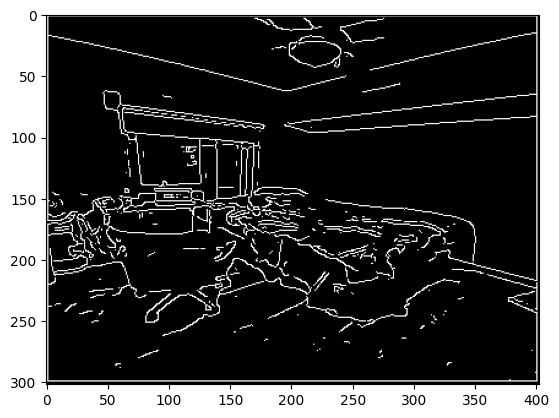

In [91]:
c = Canny()
edge = c.canny(img)
plt.imshow(edge, cmap='gray')
plt.show()